# Jacobian switching linear dynamical system (JSLDS) - context-dependent integration experiment

This notebook walks through the code required for the context-dependent integration task in the paper *Reverse engineering recurrent neural networks with Jacobian switching linear dynamical systems*. It is recommended to go through the 3-bit memory experiment notebook first.

### Runtime type

It is recommended to run this notebook using a GPU provided by Colab. If in the Google Colab environment, select Runtime>Change runtime type from the menu above to select a GPU.

### Imports

In [ ]:
# Numpy, JAX, and Matplotlib should all be correctly installed and on the 
# python path.
import time
import jax
from jax.experimental import optimizers
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
import numpy as np             # original CPU-backed NumPy
from sklearn.decomposition import PCA

Clone the JSLDS repository

In [ ]:
!git clone https://github.com/jimmysmith1919/JSLDS_public.git

Cloning into 'JSLDS_public'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 41 (delta 8), reused 37 (delta 7), pack-reused 0
Unpacking objects: 100% (41/41), done.


### Dependencies
To run this notebok you must import the following files:



*   model_and_training.py:   contains model and optimization code
*   integrator.py:           functions to generate task inputs and targets
*   fixed_point_finding.py:  contains functions to perform eigendecompositions
*   plotting.py:             some useful plotting functions
*   context_int_analysis.py: useful functions for performing subspace projection



In [ ]:
import JSLDS_public.JSLDS_code.model_and_training as JSLDS
import JSLDS_public.JSLDS_code.integrator as integrator
import JSLDS_public.JSLDS_code.plotting as plotting
import JSLDS_public.JSLDS_code.fixed_point_finding as num_fps
import JSLDS_public.JSLDS_code.context_int_analysis as analysis

##Try it out

### Reload or train new model
Upload the following file if you would like to load the trained JSLDS/cotrained RNN weights used for the experimental results in the paper:

* JSLDS_public/JSLDS_code/trained_params_jslds_context_integration_0.000819_2021-03-29_18_01_27.npz

If you would like to load the trained JSLDS model weights from the paper set reload_trained_model = True. If you would like to train a new model set this variable to False.

In [ ]:
reload_trained_model = True

### Context-dependent integration task definition

Here we define the parameters for the task definition. We also specify that we will set $\mathbf{u}^*$ based on the static context for each trial. See the context-dependent integration section of the Appendix in the paper for more details.

In [ ]:
#Contextual integration parameters
T = 1.0          # Arbitrary amount time, roughly physiological.
ntimesteps = 25  # Divide T into this many bins
bval = 0.01      # bias value limit
sval = 0.025     # standard deviation (before dividing by sqrt(dt))
input_params = (bval, sval, T, ntimesteps)
u = 4            # number of inputs
o = 1            # number of outputs in the RNN

build_partial = lambda skeys: integrator.build_inputs_and_targets(input_params,
                                                                  skeys)
build_inputs_and_targets = jax.jit(build_partial)
input_plot_batch = integrator.plot_batch

#set u_star (input to expand around in taylor approximation) to zeros (average of the inputs)
jslds_rnn = JSLDS.jslds_rnn_x_star_context

### Model Definition

### Use trained model
See the paper Appendix for the hyperparameters used for this model

In [ ]:
if reload_trained_model:
    network_path = 'JSLDS_public/JSLDS_code/trained_params_jslds_context_integration_0.000819_2021-03-29_18_01_27.npz'
    loaded_params = np.load(network_path, allow_pickle=True)
    params = loaded_params['arr_0'].item()

    batch_size = 256          # How many examples in each batch
    #If using trained model, do not change the following parameters
    n = 128             # Number of units in the RNN
    rnn_fun = JSLDS.vrnn_tanh
    rnn_hps = {'fun' : rnn_fun}  
    hps = { 'rnn' : rnn_hps}

### Train a new model


### JSLDS loss function hyperparameters
In general, we have found the JSLDS loss function strengths to be relatively easy to select. However, there are various possible configurations. The following provides a general framework for how to think about these parameters:

* $\lambda_e$ should generally be relatively large. It should be prioritized higher than the other losses or regularizers since failing to find expansion points that are good approximations of the RNN's fixed points or slow points would defeat the primary purpose of the method.
* $\lambda_a$ should be large enough to ensure a small error between the JSLDS states and the RNN states. However, for some tasks, one may need to balance tradeoffs between $R_a$ and the losses $\mathcal{L}_{\mathsf{RNN}}$ and $\mathcal{L}_{\mathsf{JSLDS}}$.
* For most of the experiments in this paper we set the loss strengths to $\lambda_{\mathsf{RNN}} = 1$ and $\lambda_{\mathsf{JSLDS}}=1$. For the 3-bit memory task, we observed slightly better performance by setting $\lambda_{\mathsf{RNN}} = 3$ and $\lambda_{\mathsf{JSLDS}}=1$. Interestingly, allowing for a slight bias towards the RNN performance on this task generally led to improved performance for both the RNN and the JSLDS. However, other variations are possible.
* For example, setting $\lambda_{\mathsf{RNN}} = 1$ and $\lambda_{\mathsf{JSLDS}}=0$ might correspond to the goal of training  a nonlinear RNN to be more interpretable by not sacrificing the goals of $R_e$ and $R_a$ for the sake of JSLDS task performance. 
* In the other extreme, if one were just interested in training an SLDS, setting $\lambda_{\mathsf{RNN}} = 0$ and $\lambda_{\mathsf{JSLDS}}=1$ could provide benefits since the JSLDS learns to share parameters across expansion points.

If you are interested in training a normal RNN (with no JSLDS regularization) in this notebook then set the hyperparameters to
*   $\lambda_e$ = 0.0
*   $\lambda_{\mathsf{RNN}}$ = 1.0
*   $\lambda_{\mathsf{JSLDS}}$= 0.0
*   $\lambda_a$ = 0.0 

In [ ]:
 if not reload_trained_model:
    # These four HPS dictate how the JSLDS is trained up. 
    fp_reg = 100.0         # \lambda_e: fixed point regularizer strength
    out_nl_reg = 1.0       # \lambda_RNN: nonlinear RNN loss strength
    out_staylor_reg = 1.0  # \lambda_JSLDS: JSLDS loss strength
    taylor_reg = 10.0      # \lambda_a: hidden state approximation regularizer

In [ ]:
if not reload_trained_model:
    # RNN hyperparameters
    n = 128       # Number of units in the RNN
    rnn_params_fun = JSLDS.vrnn_params
    rnn_fun = JSLDS.vrnn_tanh
    taylor_series_rnn_order = 1  # Taylor series expansion order

    i_factor = 1.0               # input scale
    h_factor = 0.9               # Scaling of the recurrent weight matrix
    recurrent_is_identity = False
    h_scale = 0.1          
    rnn_hps = {'u' : u, 'n' : n, 'recurrent_is_identity' : recurrent_is_identity, 
              'h_factor' : h_factor, 
              'h_scale' : h_scale, 'i_factor' : i_factor,
              'params_fun' : rnn_params_fun, 
              'fun' : rnn_fun, 'order' : taylor_series_rnn_order}  
    nlayers = 2     # of MLP layers
    hps = {'mlp' : {'nlayers' : nlayers, 'n' : n}, 
          'rnn' : rnn_hps, 
          'out' : {'u' : n, 'o' : o, 'i_factor' : 1.0}}


    # Optimization hyperparameters
    num_batchs = 50000        # Total number of batches to train on.
    batch_size = 256          # How many examples in each batch
    eval_batch_size = 1024    # Evaluation batch size
    step_size = 0.02          # initial learning rate
    decay_factor = 0.9999     # decay the learning rate this much
    max_grad_norm = 10.0      # max gradient norm before clipping
    adam_b1 = 0.9             # Adam parameters
    adam_b2 = 0.999
    adam_eps = 1e-1
    print_every = 500         # Print training information every so often

    l2_reg = 1e-5             # amount of L2 regularization on the weights


    opt_hps = {'num_batches' : num_batchs, 'batch_size' : batch_size, 
              'eval_batch_size' : eval_batch_size, 'print_every' : print_every,
              'step_size' : step_size, 'decay_factor' : decay_factor, 
              'max_grad_norm' : max_grad_norm, 
              'out_nl_reg': out_nl_reg, 'out_staylor_reg' : out_staylor_reg,
              'l2_reg' : l2_reg, 'fp_reg' : fp_reg, 'taylor_reg' : taylor_reg, 
              'adam_b1' : adam_b1, 'adam_b2': adam_b2, 'adam_eps': adam_eps}



Run this next cell regardless if you are loading the trained model or training a new model. This cell defines the initial random seed, plots an example trial, and defines a useful batch RNN function that will be used later. The first time running this cell may take a few minutes during the first jit call.

Seed: 1945


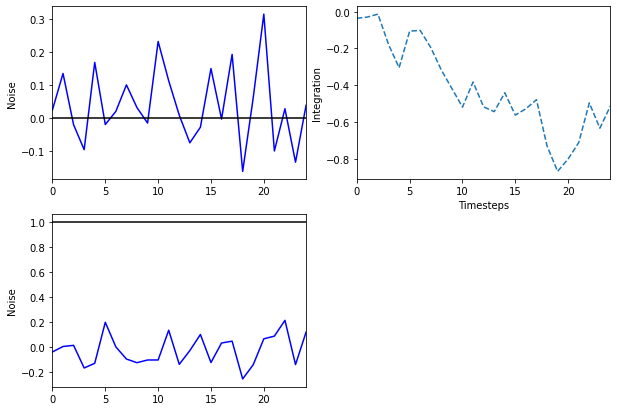

In [ ]:
# Plot input/target example and define batch RNN function

seed = 1945
print("Seed: %d" % seed)
key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

# Plot input/target examples
ntoplot = 20    # how many example one could view 

key, skey = jax.random.split(key, 2)
skeys = jax.random.split(skey, ntoplot) # get ntoplot random keys
inputs, targets, masks = build_inputs_and_targets(skeys)
# Plot the input to the RNN and the target for the RNN.
input_plot_batch(ntimesteps, inputs, targets)


def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = \
        build_inputs_and_targets(keys)
    h0s_b = None # Use trained h0
    return inputs_b, targets_b, masks_b, h0s_b


batch_rnn_run = JSLDS.get_batch_rnn_run_fun(hps['rnn']['fun'], jslds_rnn)

This next cell is only necessary if you are training a new model. It initializes the model weights and plots the evaluation of the untrained networks on example trials using the initial random weights. It shows samples of the example inputs, sample JSLDS and RNN states (the approximation quality), sample expansion points and the RNN evaluated at the expansion points (the fixed point approximation quality), and sample JSLDS and RNN outputs compared to the target. We will view this plot again after training to see the improvement.

In [ ]:
if not reload_trained_model:
    # Init some parameters for training.
    key, subkey = jax.random.split(key, 2)
    init_params = JSLDS.jslds_rnn_params(subkey, **hps)
    rnn_run = lambda inputs: batch_rnn_run(init_params, inputs)

    key, skey = jax.random.split(key)
    rnn_internals = JSLDS.run_trials(rnn_run, inputs_targets_no_h0s, 1, 16, skey)
    key, skey = jax.random.split(key)
    plotting.plot_examples(ntimesteps, rnn_internals, skey, nexamples=4)

This next cell is only necessary if you are training a new model. It defines and plots the learning rate decay function.

In [ ]:
if not reload_trained_model:
    # Create a decay function for the learning rate
    decay_fun = optimizers.exponential_decay(opt_hps['step_size'], 
                                            decay_steps=1, 
                                            decay_rate=opt_hps['decay_factor'])

    plt.figure()
    plt.subplot(111)
    batch_idxs = np.linspace(1, num_batchs)
    plt.plot(batch_idxs, [decay_fun(b) for b in batch_idxs])
    plt.axis('tight')
    plt.xlabel('Batch number')
    plt.title('Learning rate');

Run this cell to train a new JSLDS-RNN system. Should take ~30-60 minutes using Colab GPUs

In [ ]:
if not reload_trained_model:
    # Run the optimization loop, first jit'd call will take a few minutes.
    all_train_losses = []

    opt_init, opt_update, opt_get_params = \
        optimizers.adam(decay_fun, opt_hps['adam_b1'], opt_hps['adam_b2'], 
                        opt_hps['adam_eps'])
    opt_state = opt_init(init_params)
    start_time = time.time()

    for batch_idx in range(num_batchs):
        key, skey = jax.random.split(key)
        skeys = jax.random.split(skey, batch_size)
        inputs, targets, masks = build_inputs_and_targets(skeys)
        opt_state = JSLDS.update_w_gc_jit(batch_idx, opt_state, opt_update, opt_get_params, inputs,
                                    targets, masks, opt_hps['max_grad_norm'], 
                                    opt_hps['out_nl_reg'], opt_hps['out_staylor_reg'],
                                    opt_hps['taylor_reg'], opt_hps['fp_reg'], 
                                    opt_hps['l2_reg'], 
                                    hps['rnn']['fun'], jslds_rnn)
        if batch_idx % print_every == 0:
            params = opt_get_params(opt_state)
            all_train_losses.append(JSLDS.loss_jit(params, inputs, targets, masks,
                                            opt_hps['out_nl_reg'],
                                            opt_hps['out_staylor_reg'],
                                            opt_hps['taylor_reg'], 
                                            opt_hps['fp_reg'], 
                                            opt_hps['l2_reg'], 
                                            hps['rnn']['fun'], jslds_rnn))
            train_loss = all_train_losses[-1]['total']
            batch_time = time.time() - start_time
            step_size = decay_fun(batch_idx)
            s = "Batch {} in {:0.2f} sec, step size: {:0.5f}, training loss {:0.4f}"
            print(s.format(batch_idx, batch_time, step_size, train_loss))
            start_time = time.time()
            
    # List of dicts to dict of lists
    all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Plot the training results

In [ ]:
if not reload_trained_model:
    # Show the loss through training.
    x = np.arange(0, num_batchs, print_every)
    for xl1,xl2 in [(1000, num_batchs), (20000, num_batchs)]:
        xl1 = int(xl1/print_every)
        xl2 = int(xl2/print_every)

        plt.figure(figsize=(16,8))
        plt.subplot(231)
        plt.plot(x[xl1:xl2], all_train_losses['total'][xl1:xl2], 'k')
        plt.title('Total')

        plt.subplot(232)
        plt.plot(x[xl1:xl2], all_train_losses['lms_jslds'][xl1:xl2], 'r')
        plt.plot(x[xl1:xl2], all_train_losses['lms_nl'][xl1:xl2], 'r--')

        plt.legend(('JSLDS', 'RNN'))
        plt.title('Least mean square')

        plt.subplot(233)

        plt.plot(x[xl1:xl2], all_train_losses['l2'][xl1:xl2], 'g');
        plt.title('L2 regularization')

        plt.subplot(234)
        plt.plot(x[xl1:xl2], all_train_losses['fixed_point'][xl1:xl2], 'c');
        plt.title('Fixed point regularization')

        plt.subplot(235)
        plt.plot(x[xl1:xl2], all_train_losses['taylor'][xl1:xl2], 'm');
        plt.title('Taylor series regularization')


        plt.subplot(236)
        plt.plot(x[xl1:xl2], all_train_losses['total'][xl1:xl2], 'k')
        plt.plot(x[xl1:xl2], all_train_losses['lms_jslds'][xl1:xl2], 'r')
        plt.plot(x[xl1:xl2], all_train_losses['lms_nl'][xl1:xl2], 'r--')
        plt.plot(x[xl1:xl2], all_train_losses['l2'][xl1:xl2], 'g')
        plt.plot(x[xl1:xl2], all_train_losses['fixed_point'][xl1:xl2], 'c')
        plt.plot(x[xl1:xl2], all_train_losses['taylor'][xl1:xl2], 'm')
        plt.title('All losses');

Evaluate loss on a held-out set of trials. This can be computed for the uploaded trained model or the newly trained model. 

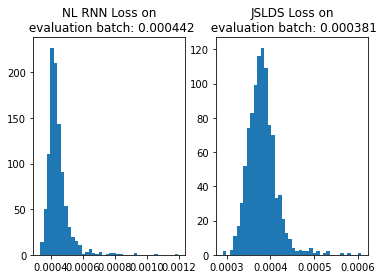

In [ ]:
# Take a batch for an evaluation loss, notice all penalties are 0 for 
#the evaluation, except for the relevant task penalty

if not reload_trained_model:
    params = opt_get_params(opt_state)

key, skey = jax.random.split(key)

ntries = 1000
eval_losses = np.zeros(ntries)
eval_losses_j = np.zeros(ntries)
for try_idx in range(ntries):
    key, subkey = jax.random.split(key, 2)
    skeys = jax.random.split(subkey, batch_size)
    inputs, targets, masks = build_inputs_and_targets(skeys)
    eval_loss = JSLDS.loss_jit(params, inputs, targets, masks,
                         1.0,
                         0.0,
                         0.0, 0.0, 0.0, 
                         hps['rnn']['fun'], jslds_rnn)['total']
    eval_losses[try_idx] = eval_loss
    eval_loss_j = JSLDS.loss_jit(params, inputs, targets, masks,
                      0.0,
                      1.0,
                      0.0, 0.0, 0.0, 
                      hps['rnn']['fun'],jslds_rnn)['total']
    eval_losses_j[try_idx] = eval_loss_j


plt.subplot(121)
eval_loss_mean = np.mean(eval_losses)
eval_loss_str = "{:.6f}".format(eval_loss_mean)
plt.title("NL RNN Loss on\n evaluation batch: %s" % (eval_loss_str))    
plt.hist(eval_losses, 40);

plt.subplot(122)
eval_loss_mean_j = np.mean(eval_losses_j)
eval_loss_str_j = "{:.6f}".format(eval_loss_mean_j)
plt.title("JSLDS Loss on\n evaluation batch: %s" % (eval_loss_str_j))    
plt.hist(eval_losses_j, 40);

Compare the loss of the co-trained nonlinear RNN (left) and the JSLDS (right)

### Visualizations of trained JSLDS-RNN system

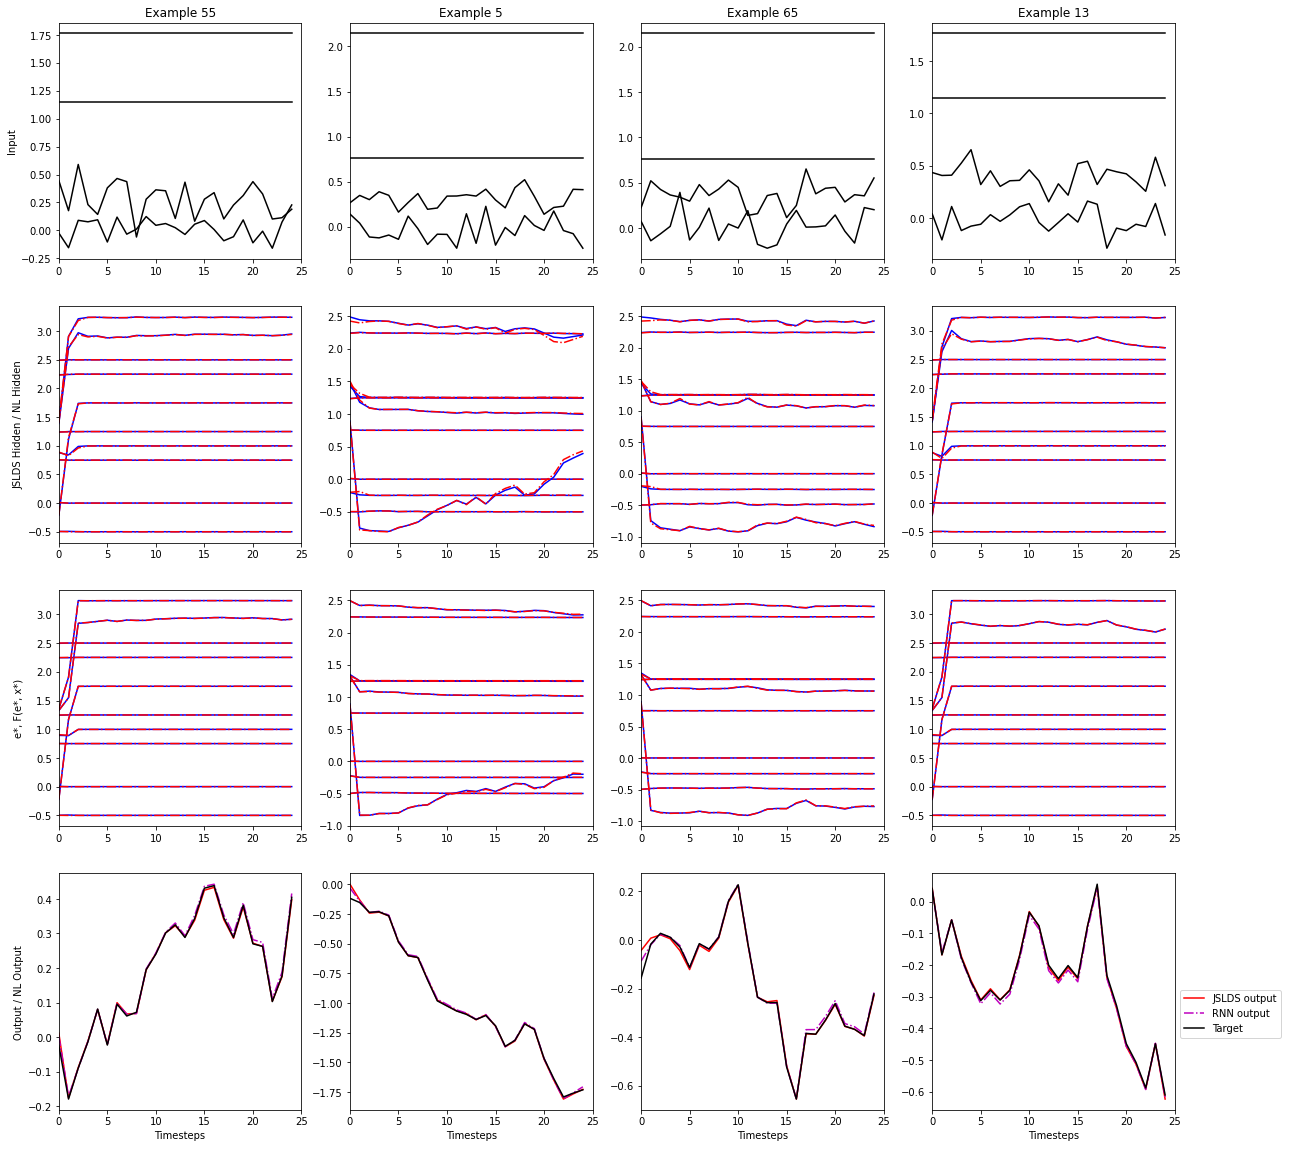

In [ ]:
# Visualize how well the trained models perform.

batch_size = 128
rnn_run = lambda inputs: batch_rnn_run(params, inputs)


key, skey = jax.random.split(key)
rnn_internals = JSLDS.run_trials(rnn_run, inputs_targets_no_h0s, 1, batch_size, skey)

key, skey = jax.random.split(key)
plotting.plot_examples(ntimesteps, rnn_internals, skey, nexamples=4)

### JSLDS approximation of co-trained RNN's dynamics

Here we evaluate the JSLDS approximation of the co-trained nonlinear RNN's dynamics. We first display example trajectories projected into PCA space. Note the JSLDS states were computed by running the JSLDS forward in time for the entire trial trajectory, as opposed to needing to resort to one-step ahead dynamics generation (which the standard reverse engineering method requires as we will see later).

In [ ]:
def pca_plot_settings(ax,fs):
    ax.set_xlabel('PC #1', fontsize=fs)
    ax.set_ylabel('PC #2', fontsize=fs)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='lower right',fontsize=fs, frameon=False)

In [ ]:
#Compute PCA
pca = PCA(n_components=2).fit(rnn_internals['nl_hiddens'].reshape(-1,n))
h_pca = pca.transform(rnn_internals['hiddens'].reshape(-1,n))
nlh_pca = pca.transform(rnn_internals['nl_hiddens'].reshape(-1,n))

Text(0.5, 1.0, 'Trial 11 JSLDS dynamics generation')

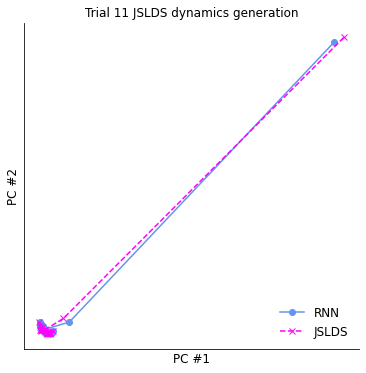

In [ ]:
#Plot PCA trajectories for example trial
trial = 11
plt.figure(figsize=(6,6))
start_idx = trial*25
stop_idx = trial*25+25

fs=12
ax=plt.subplot(111)


ax.plot(nlh_pca[start_idx:stop_idx,0], nlh_pca[start_idx:stop_idx,1], '-o', 
        color='cornflowerblue', label='RNN')
ax.plot(h_pca[start_idx:stop_idx,0], h_pca[start_idx:stop_idx,1], '--x', 
        color='magenta', label='JSLDS')
pca_plot_settings(ax,fs)
plt.title('Trial {} JSLDS dynamics generation'.format(trial), fontsize=fs)

Now compute the mean relative error,$\|\mathbf{h}_{t}^{\textsf{RNN}}-\mathbf{h}_t^{\textsf{lin}} \|_2/\|\mathbf{h}_t^{\textsf{RNN}} \|_2$,  for the approximation on a batch of held-out evaluation trials. For the JSLDS, $\mathbf{h}_t^{\textsf{lin}}$ is just the JSLDS states, $\mathbf{a}_t$, generated for the trial trajectories.

In [ ]:
from jax import vmap

def rel_error_t(h_apprx, h_true):
  def norm_diff(h_apprx, h_true):
    return jnp.linalg.norm(h_apprx-h_true, ord=2)
  return norm_diff(h_apprx, h_true)/jnp.linalg.norm(h_true, ord=2)

def rel_error(h_apprxs, h_trues):
  def rel_error_series(h_apprxs, h_trues):
    return vmap(rel_error_t, (0,0))(h_apprxs, h_trues)

  return np.mean(vmap(rel_error_series, (0,0))(h_apprxs, h_trues))



In [ ]:
#Compute relative error of JSLDS linearized approximation
mean_rel_err  = rel_error(rnn_internals['hiddens'], rnn_internals['nl_hiddens'])
print('JSLDS heldout mean relative error', mean_rel_err)

JSLDS heldout mean relative error 0.009703284


### Subspace Projection

This code block computes the expansion points, corresponding eigendecompositions, JSLDS states, and orthogonalized subspace discussed in the paper. It takes a few minutes to run.

In [ ]:
#Evaluate on batch of trials with fixed bias levels
eval_batch_size = 128
motions = [-.04, -.02, -.009, .009, .02, .04 ]  #motion biases
colors = [-.04, -.02, -.009, .009, .02, .04]   #color biases   
key, skey = jax.random.split(key)
m_hiddens,m_hstars,m_inputs,c_hiddens,c_hstars,\
c_inputs = analysis.run_trials_fixed_bias(skey, eval_batch_size, motions,
                                          colors, batch_rnn_run, params,
                                          ntimesteps, n, u)
num_trials = 36 #6 motion biases x 6 color biases

#We will take a random sample of the 128 trials computed for each of the 36 bias 
#settings. We will use these to compute the expansion points to plot and the 
#right eigenvectors to construct the choice axis. This sampling is to speed up
#the eigendecompositions required to construct the subspace.
num_samples = 5  #number of trajectories sampled for each of the 36 bias settings

#motion context
key, skey = jax.random.split(key)
hiddens_approx_c1, hstars_c1 = analysis.get_sample_expansion_points(skey,
                                                                    num_trials, 
                                                                    num_samples, 
                                                                eval_batch_size,
                                                        m_hiddens, m_hstars,
                                                        ntimesteps, n)
offset1 = 2 #it takes a couple of timesteps to get on the line attractor so 
            #we ignore these when plotting
eig_decomps_c1, new_es_c1,\
 proj_mat_c1,proj_hiddens_c1, \
 proj_hstars_c1 = analysis.get_subspace_fixed_bias(params,rnn_fun, 
                                          hiddens_approx_c1, hstars_c1,
                                          'motion', ntimesteps,offset=offset1)
m_project = m_hiddens  @ proj_mat_c1
m_project = np.mean(m_project, axis=1).real

#color context
key, skey = jax.random.split(key)
hiddens_approx_c2, hstars_c2 = analysis.get_sample_expansion_points(skey, 
                                                                    num_trials,
                                                                    num_samples,
                                                                eval_batch_size,
                                                        c_hiddens, c_hstars,
                                                        ntimesteps, n)
offset2 = 2
eig_decomps_c2, new_es_c2, \
proj_mat_c2,proj_hiddens_c2, \
proj_hstars_c2 = analysis.get_subspace_fixed_bias(params,rnn_fun, 
                                                  hiddens_approx_c2,
                                         hstars_c2, 'color', 
                                         ntimesteps,offset=offset2)
c_project = c_hiddens  @ proj_mat_c2
c_project = np.mean(c_project, axis=1).real

We can examine the eigenvalues for sample trials and timesteps computed in each context. 

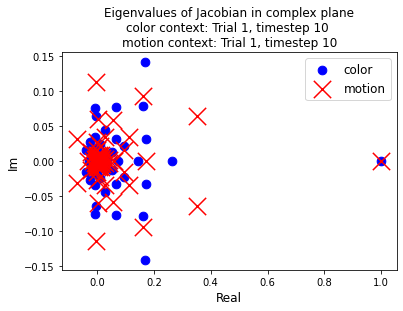

In [ ]:
fig, ax = plt.subplots(1,1)

fs=12
trial1 = 1
timestep1 = 10
example = eig_decomps_c2[trial1*ntimesteps+timestep1]['evals']
X = [x.real for x in example]
Y = [x.imag for x in example]
ax.scatter(X,Y,s=300,marker='.', alpha=1, color='blue', label='color')


trial2 = 1
timestep2 = 10
example = eig_decomps_c1[trial2*ntimesteps+timestep2]['evals']
X = [x.real for x in example]
Y = [x.imag for x in example]
ax.scatter(X,Y,s=300,marker='x', alpha=1, color='red',label='motion')

ax.legend(fontsize=fs)

ax.set_xlabel('Real', fontsize=fs)
ax.set_ylabel('Im', fontsize=fs)
ax.set_title('Eigenvalues of Jacobian in complex plane\n'+ 
          'color context: Trial {}, timestep {} \n'.format(trial1, timestep1)+
          'motion context: Trial {}, timestep {}'.format(trial2, timestep2), 
             fontsize=fs)
plt.show()


Note it takes a couple of timesteps to get on the line attractor, but after that we observe a single 1 eigenvalue, and the rest decay sharply.

Below we recreate Figure 3D-I from the paper. See the paper for a more detailed discussion. (Note the axis scaling for E-H.) D-F are trials from the motion context, and G-I are trials in the color context.

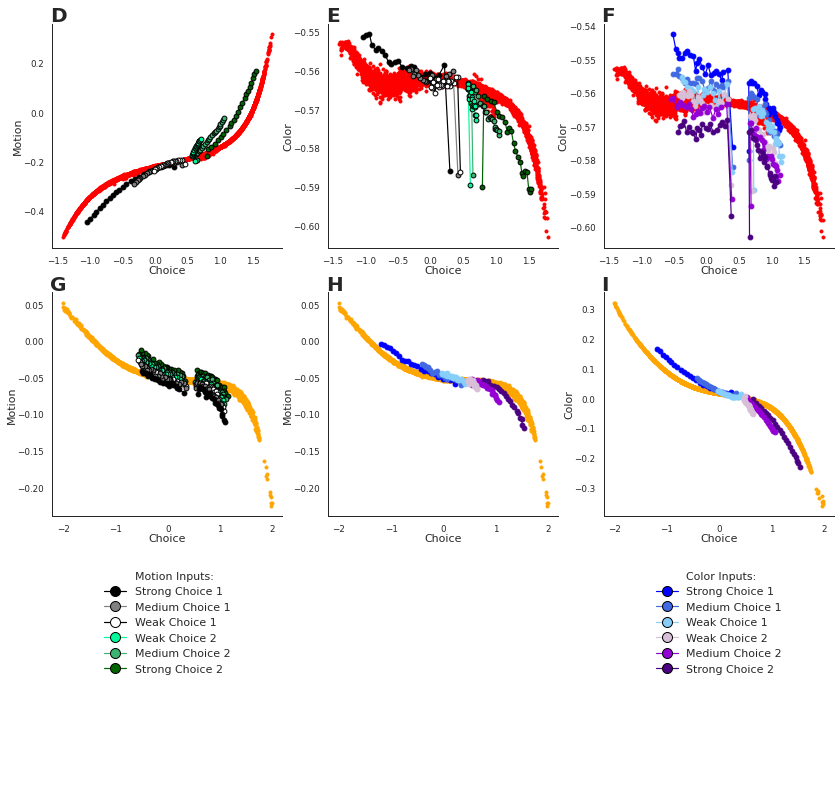

In [ ]:
analysis.plot_subspace_projection(proj_hstars_c1, proj_hstars_c2, 
                             m_project, c_project, offset1, offset2)

### Global arrangement of line attractors.
Now we will recreate the selection vector plot from Figure 3J of the paper. See paper for more details.

In [ ]:
batch_size = 128
key, skey = jax.random.split(key)
rnn_internals = JSLDS.run_trials(rnn_run, inputs_targets_no_h0s, 1, batch_size, skey)
hiddens_approx = rnn_internals['hiddens'].reshape(-1, n)
hstars = rnn_internals['h_stars'].reshape(-1,n)
inputs = rnn_internals['inputs'].reshape(-1,u)


#motion context
offset1 = 2
eig_decomps_c1, new_es_c1 , proj_mat_c1,proj_hiddens_c1,\
 proj_hstars_c1 = analysis.get_subspace(params,rnn_fun,inputs, 
                                        hiddens_approx, hstars, 'motion', 
                                        ntimesteps,offset=offset1)
#color context
offset2 = 2
eig_decomps_c2, new_es_c2, proj_mat_c2,proj_hiddens_c2,\
 proj_hstars_c2 = analysis.get_subspace(params,rnn_fun,inputs, hiddens_approx,
                                        hstars, 
                                        'color', ntimesteps,offset=offset2)

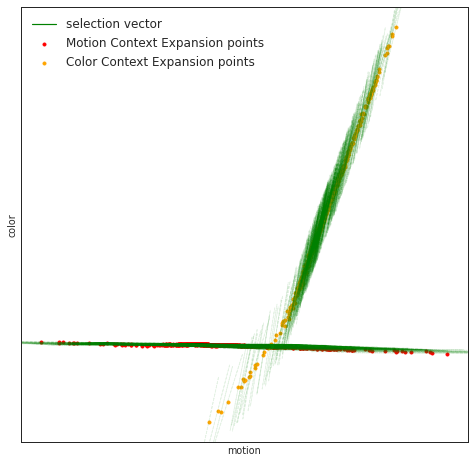

In [ ]:
#adjusting alphas changes the transparency of the green lines
alpha1 = .1 
alpha2 = .1

#adjusting scales changes the length of the green lines
scale1 = .2
scale2 = .2
analysis.selection_vector_plot(offset1, offset2, new_es_c1, new_es_c2,
                          proj_mat_c1, proj_mat_c2,
                          proj_hstars_c1.real, proj_hstars_c2.real,
                          eig_decomps_c1,eig_decomps_c2, 
                          scale1, scale2,
                          alpha1, alpha2, ntimesteps,num_trials=25)

JSLDS has learned to switch between two separate line attractors. The selection vectors (top left eigenvectors) should project strongly onto the relevant input axis.

### Compare to standard vanilla RNN

Now we will compare to the standard method of training an RNN (without JSLDS co-training), numerically finding its fixed and slow points, and linearizing around these points to reconstruct the nonlinear dynamics.

Here we load the trained weights of a standard vanilla RNN trained without JSLDS co-training

In [ ]:
network_path = 'JSLDS_public/JSLDS_code/trained_params_context_int_no_JSLDS.npz'
loaded_params2 = np.load(network_path, allow_pickle=True)
params2 = loaded_params2['arr_0'].item()

### Visualizations of standard vanilla RNN

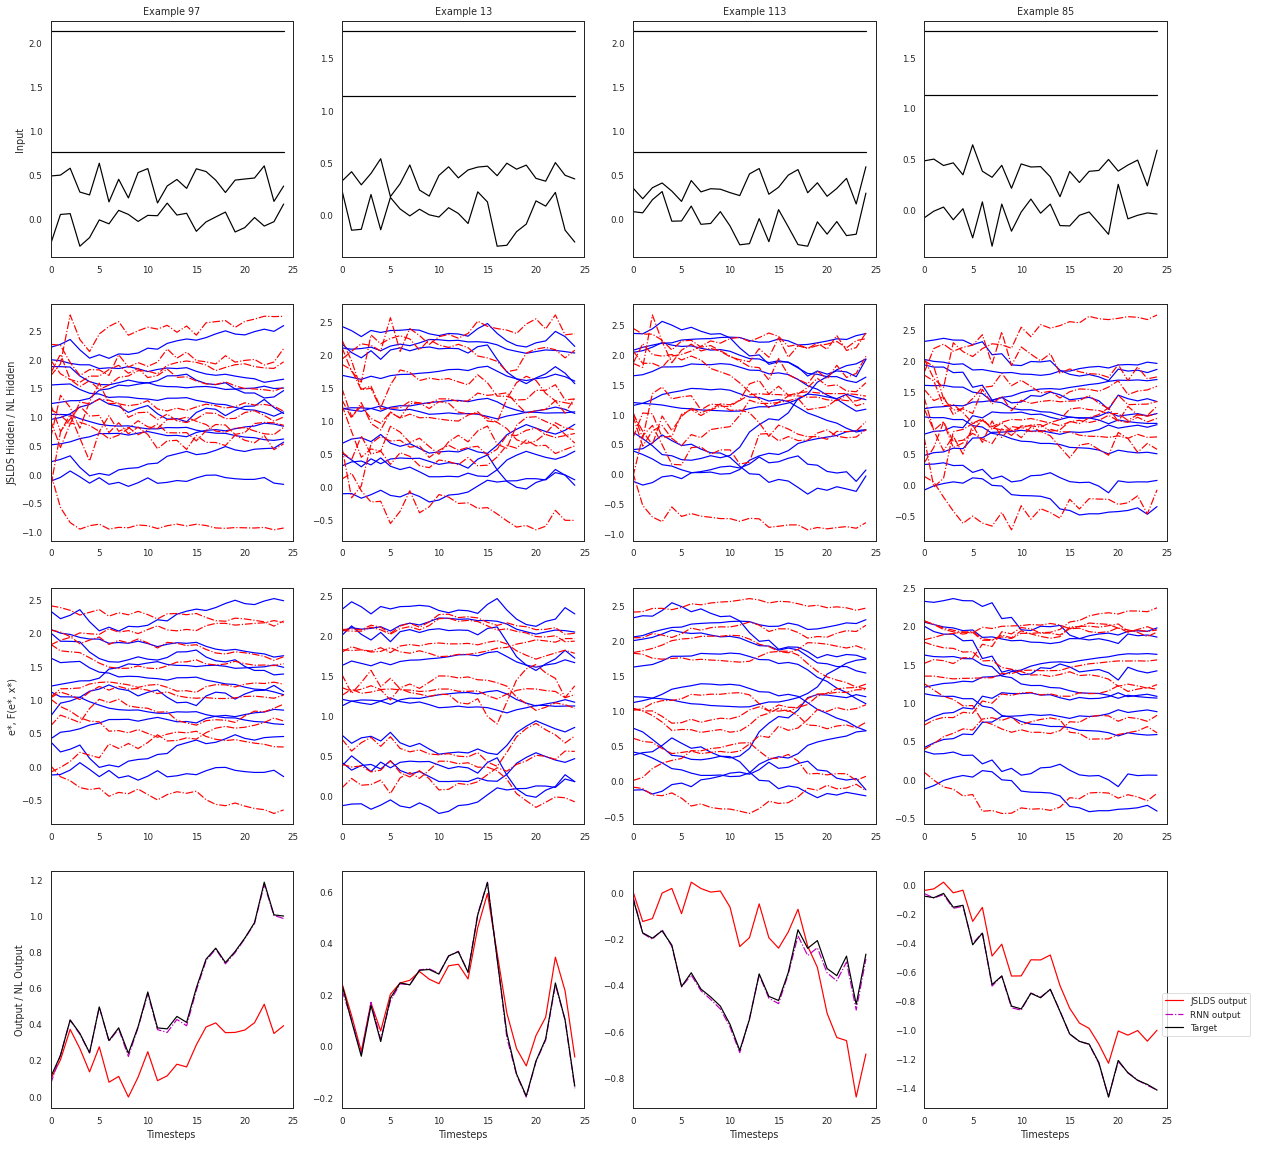

In [ ]:
# Visualize how well the trained models perform.

rnn_run = lambda inputs: batch_rnn_run(params2, inputs)


key, skey = jax.random.split(key)
rnn_internals = JSLDS.run_trials(rnn_run, inputs_targets_no_h0s, 1,
                                  batch_size, skey)

key, skey = jax.random.split(key)
plotting.plot_examples(ntimesteps, rnn_internals, skey, nexamples=4)

Note the JSLDS output and approximations above are poor since the standard GRU was not co-trained with the JSLDS. So only the RNN output lines are relevant.

For the context integration task, we have to separate out the motion context from the color context when finding the numerical fixed points since we need to use a different $\mathbf{u}^*$ for each context. 

In [ ]:
motion_inds = rnn_internals['inputs'][:,0,2]==1
color_inds = rnn_internals['inputs'][:,0,2]==0

motion_inputs = rnn_internals['inputs'][motion_inds]
print('motion inputs shape:',motion_inputs.shape)
color_inputs = rnn_internals['inputs'][color_inds]
print('color inputs shape:',color_inputs.shape)

motion_states = rnn_internals['nl_hiddens'][motion_inds]
print('motion states shape:', motion_states.shape)
color_states = rnn_internals['nl_hiddens'][color_inds]
print('color states shape:', color_states.shape)

motion inputs shape: (66, 25, 4)
color inputs shape: (62, 25, 4)
motion states shape: (66, 25, 128)
color states shape: (62, 25, 128)


Let's first consider the motion context. To find the fixed points for this context we initialize the candidate points with the states generated under the motion trials. We also set $\mathbf{u}^*=[0,0,1,0]$ for the motion context (note this is the variable x_star in the notebook.)

Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-500 in 0.38 sec, Step size: 0.77875, Training loss 0.00000
    Batches 501-1000 in 0.04 sec, Step size: 0.60645, Training loss 0.00000
    Batches 1001-1500 in 0.04 sec, Step size: 0.47228, Training loss 0.00000
    Batches 1501-2000 in 0.04 sec, Step size: 0.36779, Training loss 0.00000
    Batches 2001-2500 in 0.04 sec, Step size: 0.28642, Training loss 0.00000
    Batches 2501-3000 in 0.04 sec, Step size: 0.22305, Training loss 0.00000
    Batches 3001-3500 in 0.04 sec, Step size: 0.17370, Training loss 0.00000
    Batches 3501-4000 in 0.04 sec, Step size: 0.13527, Training loss 0.00000
    Batches 4001-4500 in 0.04 sec, Step size: 0.10534, Training loss 0.00000
    Batches 4501-5000 in 0.04 sec, Step size: 0.08203, Training loss 0.00000
    Batches 5001-5500 in 0.04 sec, Step size: 0.06388, Training loss 0.00000
    Batches 5501-6000 in 0.04 sec, Step size: 0.04975, Training loss 0.00000
    Batc

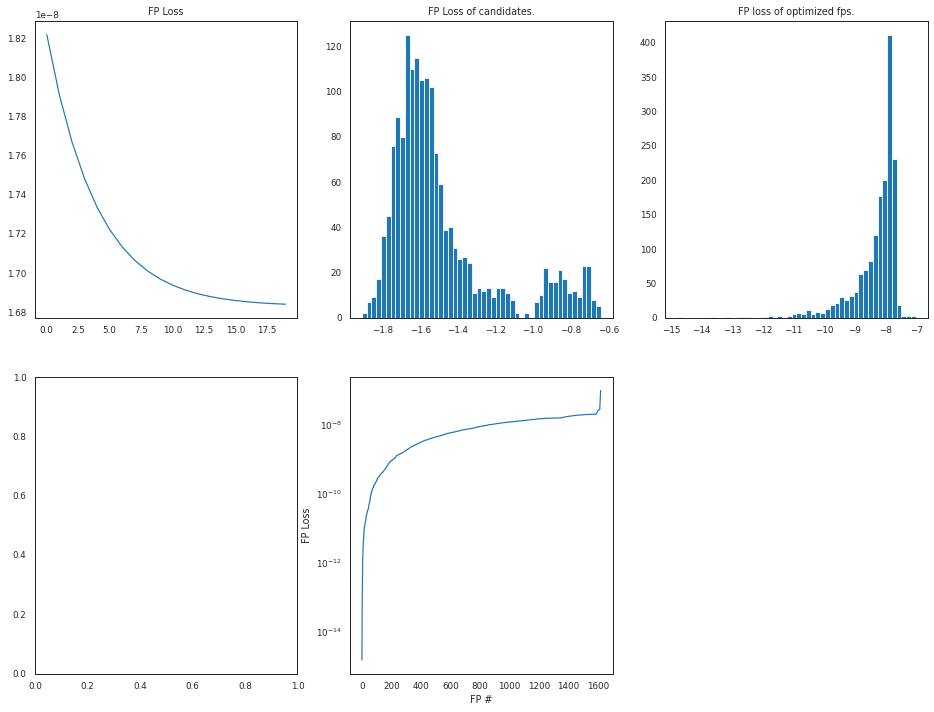

In [ ]:
# Fixed point optimization hyperparameters
fp_num_batches = 10000     # Total number of batches to train on.
fp_batch_size = 128        # How many examples in each batch
fp_step_size = 1.0         # initial learning rate
fp_decay_factor = 0.9995   # decay the learning rate this much
fp_decay_steps = 1         
fp_adam_b1 = 0.9           # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5

fp_noise_var = 0.01        # Gaussian noise added to fixed point candidates
fp_opt_print_every = 500   # Print training information during optimiziation 
fp_opt_stop_tol = 0.0
fp_tol = 0.0000001 


fp_unique_tol = 0.0         # tolerance for determination of identical fixed pts
fp_outlier_tol = np.inf     # define outlier tolerance

fp_opt_hps = {'num_batches' : fp_num_batches, 'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 
              'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : fp_opt_stop_tol, 
              'fp_tol' : fp_tol, 'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}

#For motion context

x_star = np.array([0,0,1,0])
rnn_fun_h = lambda h : rnn_fun(params2['rnn'], h, x_star)


batch_rnn_fun_h = jax.vmap(rnn_fun_h, in_axes=(0,))
fp_loss_fun = num_fps.get_fp_loss_fun(rnn_fun_h)
total_fp_loss_fun = num_fps.get_total_fp_loss_fun(rnn_fun_h)



fp_candidates = np.reshape(motion_states, (-1, n))

fps_m, fp_losses, fp_idxs, fp_opt_details = \
    num_fps.find_fixed_points(rnn_fun_h, fp_candidates, fp_opt_hps, 
                              do_print=True)


plt.figure(figsize=(16,12))
plt.subplot(231)
plt.plot(fp_opt_details['fp_losses'])
plt.title('FP Loss')
plt.subplot(232)
plt.hist(np.log10(fp_loss_fun(fp_candidates)), 50)
plt.title('FP Loss of candidates.')
plt.subplot(233)
plt.hist(np.log10(fp_loss_fun(fps_m)), 50);
plt.title('FP loss of optimized fps.')
plt.subplot(234)
plt.subplot(235)
plt.semilogy(fp_losses)
plt.xlabel('FP #')
plt.ylabel('FP Loss');

### Standard vanilla RNN linearized dynamics generation

To generate dynamics trajectories for a standard RNN, we have to linearize around the numerical fixed points. As discussed in the paper, since there is no direct link between the numerical fixed points and points in state space, we have to employ some decision criteria. Here we just choose the closest fixed point.

In [ ]:
def get_nearest_fp(fps, ha_tm1):
  """Helper function to find the nearest fixed point to our current point 
  in state space"""
  euc_dists = np.sqrt(np.sum((fps-ha_tm1)**2, axis=1))
  return fps[np.argmin(euc_dists)]

#Compute pca on the standard vanilla RNN hidden states for the motion context.
pca = PCA(n_components=2).fit(motion_states.reshape(-1,n))
h_pca = pca.transform(motion_states.reshape(-1,n))

First, we try to fully simulate the dynamics forward for the entire trajectory given the trial inputs.

Text(0.5, 1.0, 'Trial 5 Linearized approximation\n simulating dynamics forward')

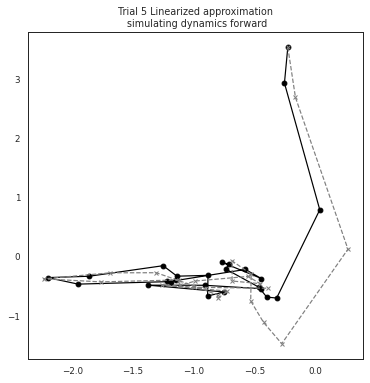

In [ ]:
# try to run all the way
trial = 5
h_approxs = np.zeros((ntimesteps, n))
ha_tm1 = motion_states[trial, 0] #start with intial RNN state
h_approxs[0] = ha_tm1
for i in range(1,ntimesteps):
  h_star = get_nearest_fp(fps_m, ha_tm1) #get nearest fixed point
  ha_tm1= JSLDS.taylor_approx_rnn(rnn_fun, params2['rnn'], h_star, x_star, 
                                  ha_tm1, motion_inputs[trial,i], 1)
  h_approxs[i] = ha_tm1

h_approxs_pca = pca.transform(h_approxs)


plt.figure(figsize=(6,6))
start_idx = trial*25
stop_idx = trial*25+25

ax=plt.subplot(111)
ax.plot(h_pca[start_idx:stop_idx,0], h_pca[start_idx:stop_idx,1], '-o',
        color='black', label='RNN')
ax.plot(h_approxs_pca[:,0], h_approxs_pca[:,1], '--x', color='gray', 
        label='Linearized')
plt.title('Trial {} Linearized approximation\n simulating dynamics forward'.format(trial))

We see that the linearized dynamics accumulate errors each timestep and for most trials  diverge significantly. So instead we resort to one-step ahead dynamics generation. For each state update of the trajectory, we provide the linearized state update equation the true previous state of the RNN. 

Text(0.5, 1.0, 'Trial 5 Linearized approximation\n one step ahead dynamics generation')

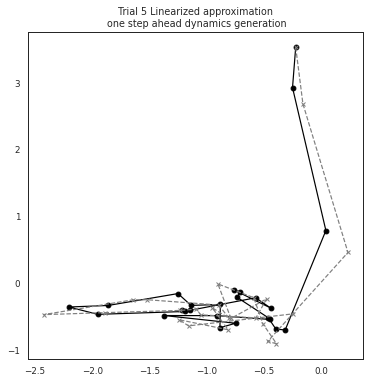

In [ ]:
# One step ahead
trial = 5
h_approxs = np.zeros((ntimesteps, n))
ha_tm1 = motion_states[trial, 0] #start with intial RNN state
h_approxs[0] = ha_tm1
for i in range(1,ntimesteps):
  h_star = get_nearest_fp(fps_m, ha_tm1) #get nearest fixed point
  ha_tm1= JSLDS.taylor_approx_rnn(rnn_fun, params2['rnn'], h_star, x_star, 
                                  ha_tm1, motion_inputs[trial,i], 1)
  h_approxs[i] = ha_tm1
  ha_tm1 = motion_states[trial, i] #provide true state

h_approxs_pca = pca.transform(h_approxs)


plt.figure(figsize=(6,6))
start_idx = trial*25
stop_idx = trial*25+25

ax=plt.subplot(111)
ax.plot(h_pca[start_idx:stop_idx,0], h_pca[start_idx:stop_idx,1], '-o',
        color='black', label='RNN')
ax.plot(h_approxs_pca[:,0], h_approxs_pca[:,1], '--x', color='gray', 
        label='Linearized')
plt.title('Trial {} Linearized approximation\n one step ahead dynamics generation'.format(trial))

This is better, but still not great compared to the JSLDS approximation (which fully simulates the dynamics forward given the trial inputs) displayed above.

Now we compute the mean relative error of the one-step ahead dynamics approximation for an evaluation batch of held-out trials. This code block is a bit slow.

In [ ]:
h_approxs = np.zeros((motion_states.shape[0], ntimesteps, n))

for b in range(motion_states.shape[0]):
    ha_tm1 = motion_states[b, 0] #start with initial RNN state
    h_approxs[b,0] = ha_tm1

    for i in range(1,ntimesteps):
      h_star = get_nearest_fp(fps_m, ha_tm1) #get nearest fixed point

      h_approxs[b,i] = JSLDS.taylor_approx_rnn(rnn_fun, params2['rnn'], h_star, 
                                               x_star, 
                                      ha_tm1, motion_inputs[b,i], 1)
      ha_tm1 = motion_states[trial, i] #use true

#don't include first state since it is given
h_approxs_motion = h_approxs
#Compute relative error of JSLDS linearized approximation
motion_mean_rel_err  = rel_error(h_approxs_motion[:,1:], motion_states[:,1:])
print('Motion mean relative error:', motion_mean_rel_err)

Motion mean relative error 0.50268584


Now we consider the color context. To find the fixed points for this context we initialize the candidate points with the states generated under the color trials. We also set $\mathbf{u}^*=[0,0,0,1]$ for the color context (note this is the variable x_star in the notebook.)

Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-500 in 0.36 sec, Step size: 0.77875, Training loss 0.00000
    Batches 501-1000 in 0.04 sec, Step size: 0.60645, Training loss 0.00000
    Batches 1001-1500 in 0.04 sec, Step size: 0.47228, Training loss 0.00000
    Batches 1501-2000 in 0.04 sec, Step size: 0.36779, Training loss 0.00000
    Batches 2001-2500 in 0.04 sec, Step size: 0.28642, Training loss 0.00000
    Batches 2501-3000 in 0.04 sec, Step size: 0.22305, Training loss 0.00000
    Batches 3001-3500 in 0.04 sec, Step size: 0.17370, Training loss 0.00000
    Batches 3501-4000 in 0.04 sec, Step size: 0.13527, Training loss 0.00000
    Batches 4001-4500 in 0.04 sec, Step size: 0.10534, Training loss 0.00000
    Batches 4501-5000 in 0.04 sec, Step size: 0.08203, Training loss 0.00000
    Batches 5001-5500 in 0.04 sec, Step size: 0.06388, Training loss 0.00000
    Batches 5501-6000 in 0.04 sec, Step size: 0.04975, Training loss 0.00000
    Batc

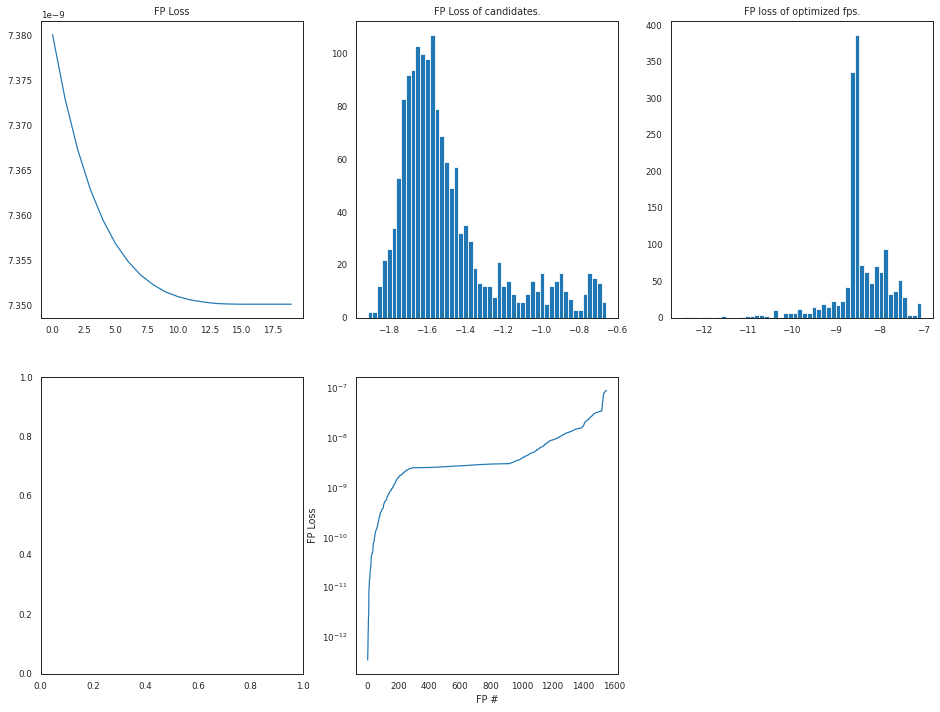

In [ ]:
# Fixed point optimization hyperparameters
fp_num_batches = 10000     # Total number of batches to train on.
fp_batch_size = 128        # How many examples in each batch
fp_step_size = 1.0         # initial learning rate
fp_decay_factor = 0.9995   # decay the learning rate this much
fp_decay_steps = 1         
fp_adam_b1 = 0.9           # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5

fp_noise_var = 0.01        # Gaussian noise added to fixed point candidates
fp_opt_print_every = 500   # Print training information during optimiziation 
fp_opt_stop_tol = 0.0
fp_tol = 0.0000001 


fp_unique_tol = 0.0         # tolerance for determination of identical fixed pts
fp_outlier_tol = np.inf     # define outlier tolerance

fp_opt_hps = {'num_batches' : fp_num_batches, 'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 
              'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : fp_opt_stop_tol, 
              'fp_tol' : fp_tol, 'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}

#For color context
x_star = np.array([0,0,0,1])
rnn_fun_h = lambda h : rnn_fun(params2['rnn'], h, x_star)


batch_rnn_fun_h = jax.vmap(rnn_fun_h, in_axes=(0,))
fp_loss_fun = num_fps.get_fp_loss_fun(rnn_fun_h)
total_fp_loss_fun = num_fps.get_total_fp_loss_fun(rnn_fun_h)



fp_candidates = np.reshape(color_states, (-1, n))

fps_c, fp_losses, fp_idxs, fp_opt_details = \
    num_fps.find_fixed_points(rnn_fun_h, fp_candidates, fp_opt_hps, 
                              do_print=True)


plt.figure(figsize=(16,12))
plt.subplot(231)
plt.plot(fp_opt_details['fp_losses'])
plt.title('FP Loss')
plt.subplot(232)
plt.hist(np.log10(fp_loss_fun(fp_candidates)), 50)
plt.title('FP Loss of candidates.')
plt.subplot(233)
plt.hist(np.log10(fp_loss_fun(fps_c)), 50);
plt.title('FP loss of optimized fps.')
plt.subplot(234)
plt.subplot(235)
plt.semilogy(fp_losses)
plt.xlabel('FP #')
plt.ylabel('FP Loss');

In [ ]:
#Compute pca on the standard vanila RNN hidden states for the color context.
pca = PCA(n_components=2).fit(color_states.reshape(-1,n))
h_pca = pca.transform(color_states.reshape(-1,n))

First, we try to fully simulate the dynamics forward for the entire trajectory given the trial inputs.

Text(0.5, 1.0, 'Trial 5 Linearized approximation\n simulating dynamics forward')

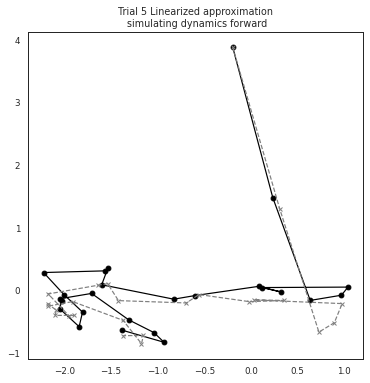

In [ ]:
# try to run all the way
trial = 5
h_approxs = np.zeros((ntimesteps, n))
ha_tm1 = color_states[trial, 0] #start with intial RNN state
h_approxs[0] = ha_tm1
for i in range(1,ntimesteps):
  h_star = get_nearest_fp(fps_c, ha_tm1) #get nearest fixed point
  ha_tm1= JSLDS.taylor_approx_rnn(rnn_fun, params2['rnn'], h_star, x_star, 
                                  ha_tm1, color_inputs[trial,i], 1)
  h_approxs[i] = ha_tm1

h_approxs_pca = pca.transform(h_approxs)


plt.figure(figsize=(6,6))
start_idx = trial*25
stop_idx = trial*25+25

ax=plt.subplot(111)
ax.plot(h_pca[start_idx:stop_idx,0], h_pca[start_idx:stop_idx,1], '-o',
        color='black', label='RNN')
ax.plot(h_approxs_pca[:,0], h_approxs_pca[:,1], '--x', color='gray', 
        label='Linearized')
plt.title('Trial {} Linearized approximation\n simulating dynamics forward'.format(trial))

We see that the linearized dynamics accumulate errors each timestep and for most trials  diverge significantly. So instead we resort to one-step ahead dynamics generation. For each state update of the trajectory, we provide the linearized state update equation the true previous state of the RNN. 

Text(0.5, 1.0, 'Trial 5 Linearized approximation\n one step ahead dynamics generation')

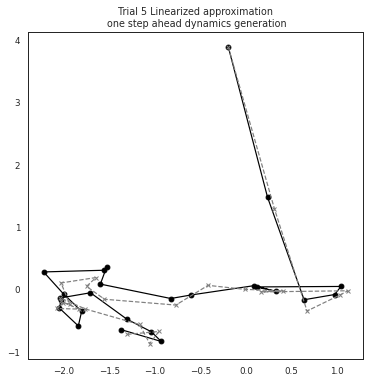

In [ ]:
trial = 5
h_approxs = np.zeros((ntimesteps, n))
ha_tm1 = color_states[trial, 0] #start with intial RNN state
h_approxs[0] = ha_tm1
for i in range(1,ntimesteps):
  h_star = get_nearest_fp(fps_c, ha_tm1) #get nearest fixed point
  ha_tm1= JSLDS.taylor_approx_rnn(rnn_fun, params2['rnn'], h_star, x_star, 
                                  ha_tm1, color_inputs[trial,i], 1)
  h_approxs[i] = ha_tm1 
  ha_tm1 = color_states[trial, i]  #Set current state to RNN state

h_approxs_pca = pca.transform(h_approxs)


plt.figure(figsize=(6,6))
start_idx = trial*25
stop_idx = trial*25+25

ax=plt.subplot(111)
ax.plot(h_pca[start_idx:stop_idx,0], h_pca[start_idx:stop_idx,1], '-o',
        color='black', label='RNN')
ax.plot(h_approxs_pca[:,0], h_approxs_pca[:,1], '--x', color='gray', 
        label='Linearized')
plt.title('Trial {} Linearized approximation\n one step ahead dynamics generation'.format(trial))

This is better, but still not great compared to the JSLDS approximation (which fully simulates the dynamics forward) displayed above.

Now we compute the mean relative error of the one-step ahead dynamics approximation for an evaluation batch of held-out trials. This code block is a bit slow.

In [ ]:
h_approxs = np.zeros((color_states.shape[0], ntimesteps, n))

for b in range(color_states.shape[0]):
    ha_tm1 = color_states[b, 0] #start with initial RNN state
    h_approxs[b,0] = ha_tm1

    for i in range(1,ntimesteps):
      h_star = get_nearest_fp(fps_c, ha_tm1) #get nearest fixed point

      h_approxs[b,i] = JSLDS.taylor_approx_rnn(rnn_fun, params2['rnn'], h_star, 
                                               x_star, 
                                      ha_tm1, color_inputs[b,i], 1)
      ha_tm1 = color_states[b, i] #use true current state

#don't include first state since it is given
h_approxs_color = h_approxs
#Compute relative error of JSLDS linearized approximation
color_mean_rel_err  = rel_error(h_approxs_color[:,1:], color_states[:,1:])
print('color mean relative error:', color_mean_rel_err)

color mean relative error 0.26720926


Now compute the mean relative error for both contexts and compare to the JSLDS mean relative error.

In [ ]:
h_apprx = np.concatenate((h_approxs_motion, h_approxs_color), axis=0)
states = np.concatenate((motion_states, color_states), axis=0)

mean_rel_err2  = rel_error(h_apprx[:,1:], states[:,1:])
print('JSLDS mean relative error:        ', mean_rel_err)
print('Linearized RNN mean relative error:', mean_rel_err2)

JSLDS mean relative error.         0.009703284
Linearized RNN mean relative error 0.38862687


We compare this one-step ahead linearized dynamics mean relative error for the standard method to the fully simulated JSLDS mean relative error (calculated earlier in this notebook). The JSLDS provides a large reduction in error and allows for simulating an entire trajectory accurately. For the paper, we retrained both the JSLDS/co-trained RNN and the standard vanilla RNN 10 different times each from different random weight initializations and report the mean and standard deviation of the resulting mean relative error for each run.